In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
train = pd.read_csv("I:/train.csv")
test = pd.read_csv("I:/test.csv")
train_notarget = train.drop(["Survived"], axis=1)
complete = train_notarget.append(test, ignore_index=True)

# Veri temizliği

#Yaştaki NaN değerleri veri setinin yaş ortalamasıyla doldurmak ideal gibi

#Kabin kolonunu düşürmek gerek, herhangi bir imputation metodu uygulamak için çok az kullanılabilir veri var

#Embarked kolonundaki iki NaN satırı düşürmek gerek
train.info()

train.head(15)

train.Embarked.value_counts()

train.dropna(subset=["Embarked"], inplace=True)
train.drop("Cabin", axis=1, inplace=True)

#Yaş sütunu hariç her sütunda 889 satır var, Age sütununu da ortalamalarla doldurunca 889 olacak
train.info()

#Yaş sütununu da ortalama yaşı kullanarak doldurdum
mean_age = train.Age.mean()
train.fillna(value=mean_age, inplace=True)
train.info()

#Object veri tiplerini int64'e çevirerek matematiksel işlem yapılabilecek hale getirdim.
train.replace({"male":0, "female":1}, inplace = True)
train.replace({"S":0, "C":1, "Q":2}, inplace = True)

#Yolcu isimleri ve bilet kodları algoritma tarafından kullanılabilecek sayısal girdilere çevrilemez, bu yüzden düşürülmesi gerek.
#Ayrıca PassengerId sütununun da her ne kadar int64 olsa da yorumlanabilir (en azından benim yorumlayabileceğim) bir sayısal değer olmamasından ötürü düşürülmesi şart.
train.drop(["Ticket", "PassengerId"], axis=1, inplace=True)

#Veri temiz ve işlenmeye hazır duruyor.
train.info()
train.columns

# Feature engineering

#Boş bir küme oluşturup train veri setindeki tüm isimleri tarayıp virgülle ayrıldıktan sonra
#ikinci sırada gelen sözcüğü bu boş kümeye eklettim. Yani kişinin unvanını. Ardından unvanın
#sonundaki noktayı kaldırdım.
titles = set()
for name in train["Name"]:
    titles.add(name.split(",")[1].split(".")[0].strip())

#Kümedeki unvanları gemi memurları, asiller, kadın ve erkekler olacak şekilde dictionary içerisinde
#sınıflara ayırdım.
title_dict = {'Capt':"Officer",
 'Col':"Officer",
 'Don':"Royal",
 'Dr':"Officer",
 'Jonkheer':"Royal",
 'Lady':"Royal",
 'Major':"Officer",
 'Master':"Royal",
 'Miss':"Mrs",
 'Mlle':"Mrs",
 'Mme':"Mrs",
 'Mr':"Mr",
 'Mrs':"Mrs",
 'Ms':"Mrs",
 'Rev':"Officer",
 'Sir':"Royal",
 'the Countess':"Royal"}

#Ardından bu sınıfları veri setindeki unvanlara uygulayarak title adında yeni bir feature kolonu oluşturdum.
train["title"] = train["Name"].map(lambda name: name.split(",")[1].split(".")[0].strip())
train["title"] = train["title"].map(title_dict)
train.title.value_counts()
train.replace({"Mr":1, "Mrs":2, "Royal":3, "Officer":4}, inplace=True)

#Kadınlar ve çocuklar daha fazla hayatta kaldığından 
#yaş ortalamasının altındaki kadınları gösteren bir kolon
#belki bir şeyler anlatabilir.
train["young_female"] = (train["Age"] <= train.Age.mean()) & (train["Sex"] == 1)
train["young_female"] = train["young_female"].astype("int64")
train.young_female.isna().value_counts()

#Yukarıdaki hücre ile aynı işlem sayılır, yalnızca "ve" operatörünü "veya" ile
#değiştirdim. Yani gemidekilerin ortalama yaşında ya da ortalamadan daha genç
#kişiler veya kadın olanları barındıran bir kolon ekledim. 
train["young_or_female"] = (train["Age"] <= train.Age.mean()) | (train["Sex"] == 1)
train["young_or_female"] = train["young_or_female"].astype("int64")
train.young_or_female.isna().value_counts()

#Kişilerin gemide kaç akrabası (çocuk ve eş/kardeş) olduğunu gösteren bir kolon oluşturdum 
train["family_count"] = train["SibSp"] + train["Parch"]
train["family_count"].astype("int64")
train.family_count.value_counts()

#Gemide akrabası olanların yaşam oranıyla alakalı bir farklılık olabilir.
train["has_family"] = (train["SibSp"] + train["Parch"]) > 0
train["has_family"].astype("int64")
train.has_family.value_counts()

#Gemide akrabası olmayanların da yaşam oranıyla alakalı bir farklılık olabilir.
train["no_family"] = (train["SibSp"] + train["Parch"]) <= 0
train["no_family"].astype("int64")
train.has_family.value_counts()

#Gemideki ortalama aile bireyi sayısının üzerinde akrabası olanları gösteren bir kolon oluşturdum.
train["crowded_family"] = train["family_count"] > train["family_count"].mean()
train["crowded_family"].astype("int64")
train.crowded_family.value_counts()

#Yolcuların sınıfı ve yaşları arasında negatif bir korelasyon var, yani genç yolcular genelde
#daha alt sınıflardan bilet almışlar. Buna karşın, genç yolcuların gemiden öncelikli biçimde
#tahliye edildiği verisine de sahibiz. Bu çelişen iki girdiyi tek bir kolonda topladım.
train["age_and_class"] = (train["Age"] <= train.Age.mean()) | (train["Pclass"] == 1)
train["age_and_class"] = train["age_and_class"].astype("int64")
train.age_and_class.isna().value_counts()

#Gemiye bindikleri yere göre en çok ölüm Southampton'dan çıkmış. Southampton'dan
#binenleri gösteren bir kolon oluşturdum.
train["embarkloc"] = (train["Embarked"] == 0)
train["embarkloc"] = train["embarkloc"].astype("int64")
train.embarkloc.isna().value_counts()

#Yolcuların sınıfı ve yaşları arasında negatif bir korelasyon var, yani genç yolcular genelde
#daha alt sınıflardan bilet almışlar. Buna karşın, genç yolcuların gemiden öncelikli biçimde
#tahliye edildiği verisine de sahibiz. Bu çelişen iki girdiyi tek bir kolonda topladım.
train["high_fare"] = (train["Fare"] >= train.Fare.mean()) | (train["Pclass"] == 1)
train["high_fare"] = train["high_fare"].astype("int64")
train.high_fare.isna().value_counts()

# Veri görselleştirme

Text(0.5, 1.0, 'Kolonların korelasyon matrisi')

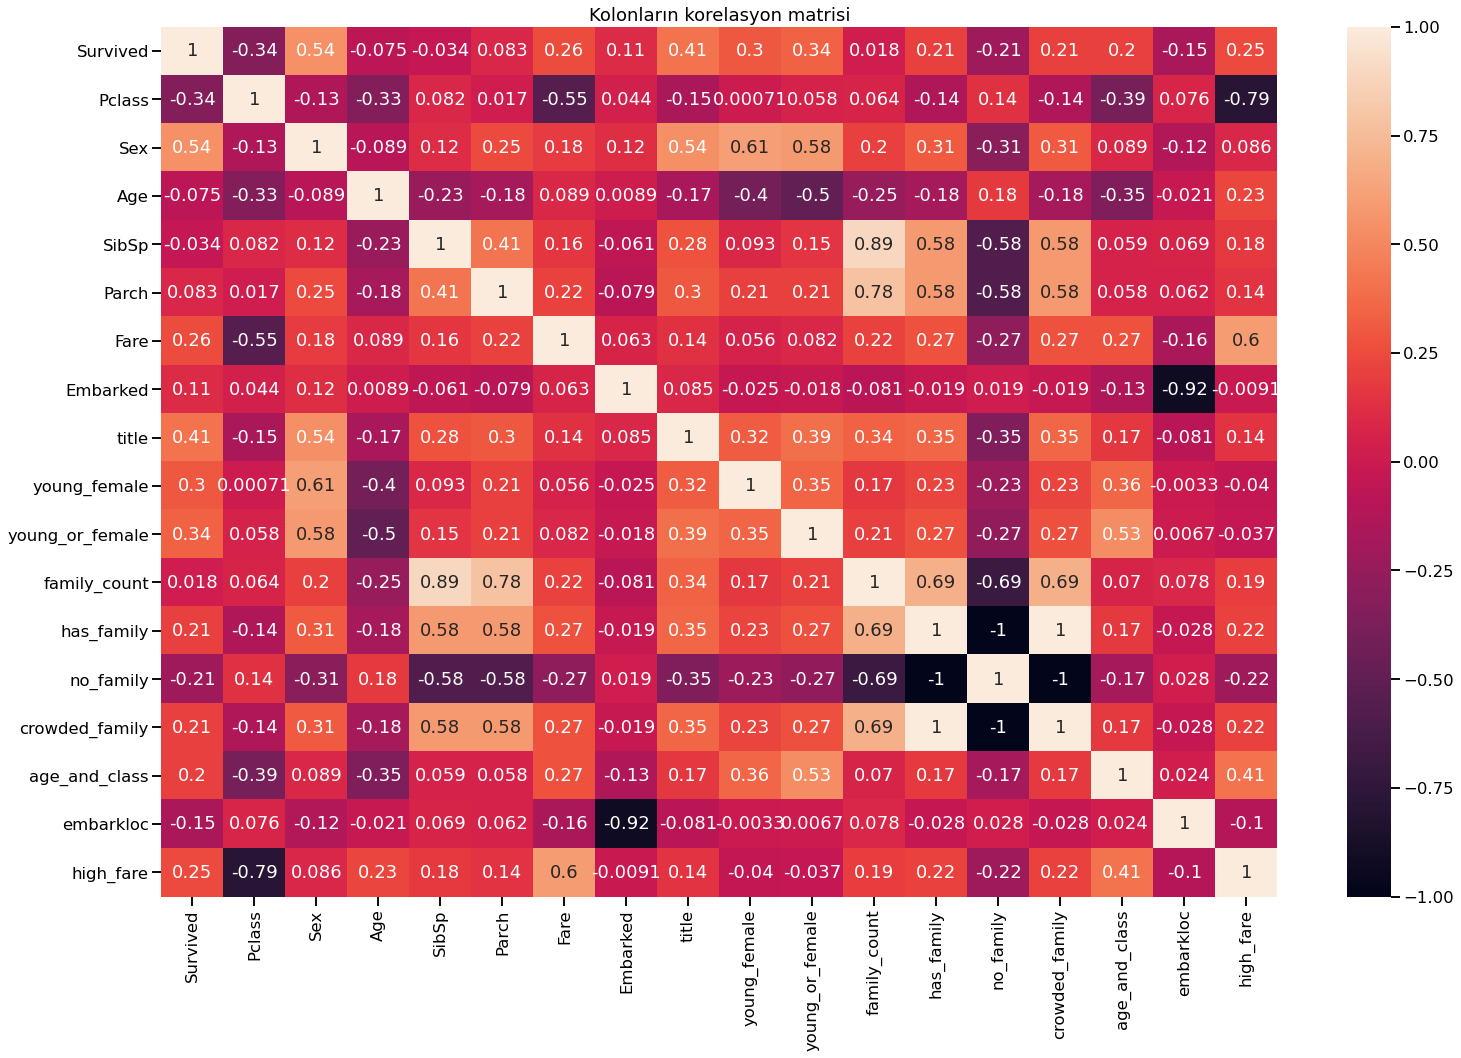

In [3]:
#Korelasyon matrisini çizelim
sns.set_context("talk")
ax = plt.subplots(figsize=(25, 16))
sns.heatmap(train.corr(), annot=True)
plt.title("Kolonların korelasyon matrisi")

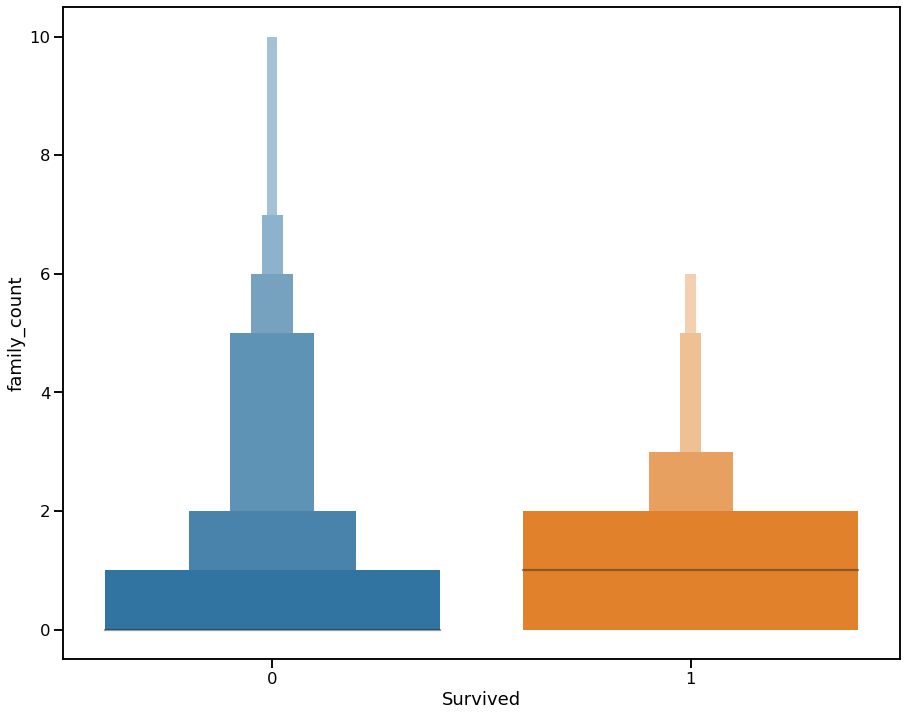

In [4]:
plt.figure(figsize=(15, 12))
sns.boxenplot("Survived","family_count",data=train)

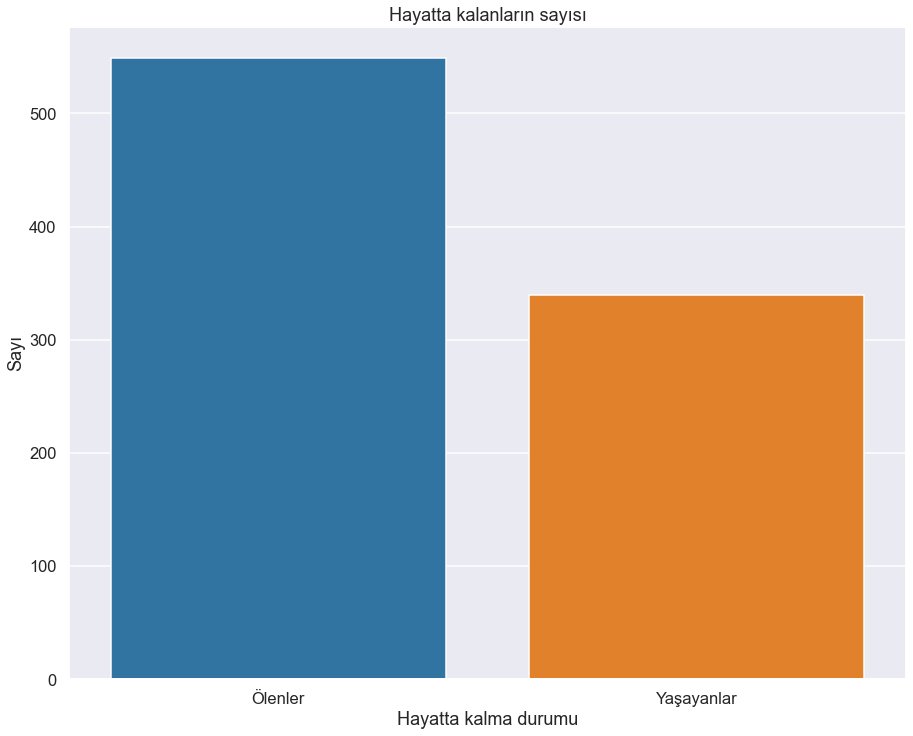

In [5]:
#Hayatta kalan ve ölenlerin sayısı
sns.set_context("talk")
sns.set_style("darkgrid")
plt.figure(figsize=(15, 12))
g = sns.countplot("Survived", data=train)
plt.title("Hayatta kalanların sayısı")
plt.xlabel("Hayatta kalma durumu")
plt.ylabel("Sayı")
g.set_xticklabels(["Ölenler", "Yaşayanlar"])
plt.show()

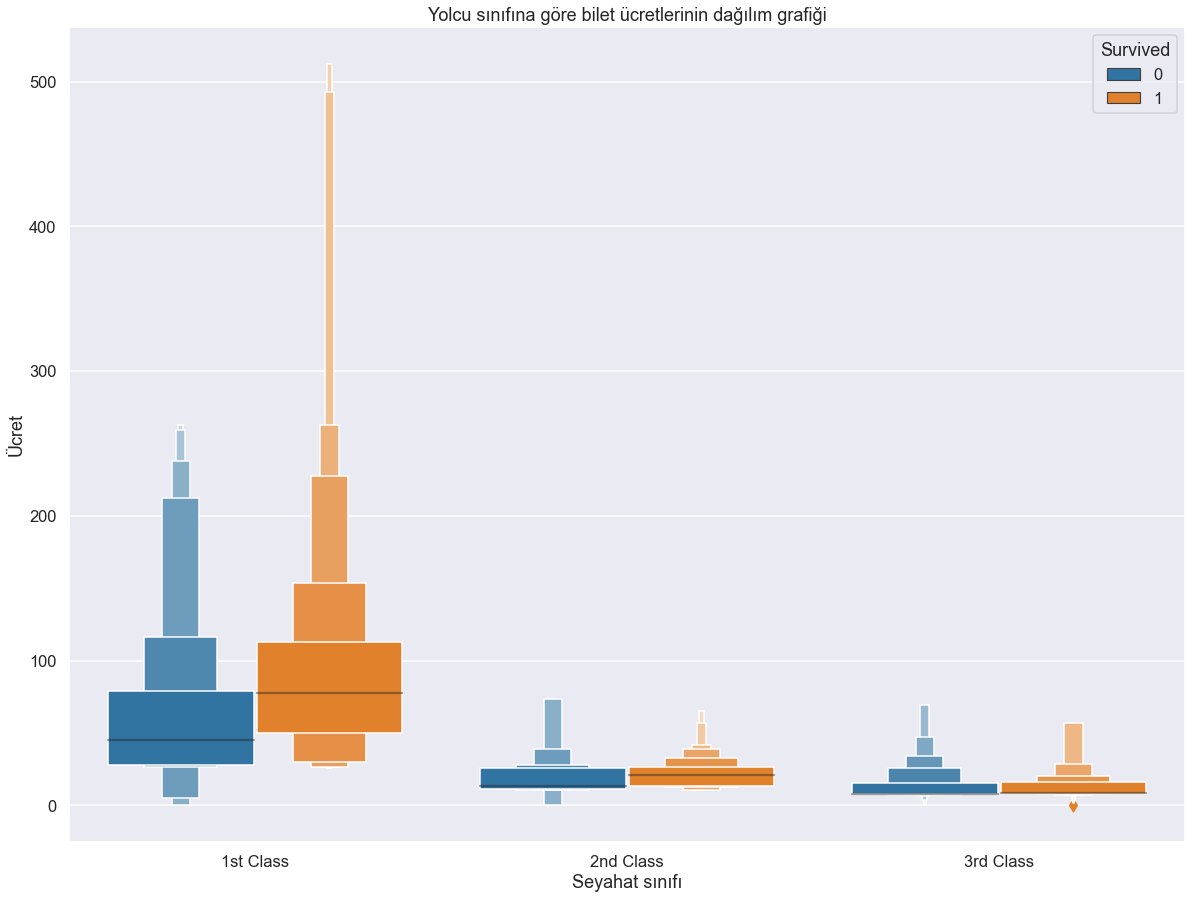

In [6]:
#Yolcuların hangi sınıfta seyahat ettiğine göre bilete ödedikleri ücretin dağılımını gösteren kutu grafiği
sns.set_context("talk")
plt.figure(figsize=(20, 15))
g1 = sns.boxenplot("Pclass", "Fare", hue="Survived", data=train)
g1.set_xticklabels(["1st Class", "2nd Class", "3rd Class"])
plt.title("Yolcu sınıfına göre bilet ücretlerinin dağılım grafiği")
plt.ylabel("Ücret")
plt.xlabel("Seyahat sınıfı")
plt.show()

Text(0, 0.5, 'Hayatta kalma yüzdeleri')

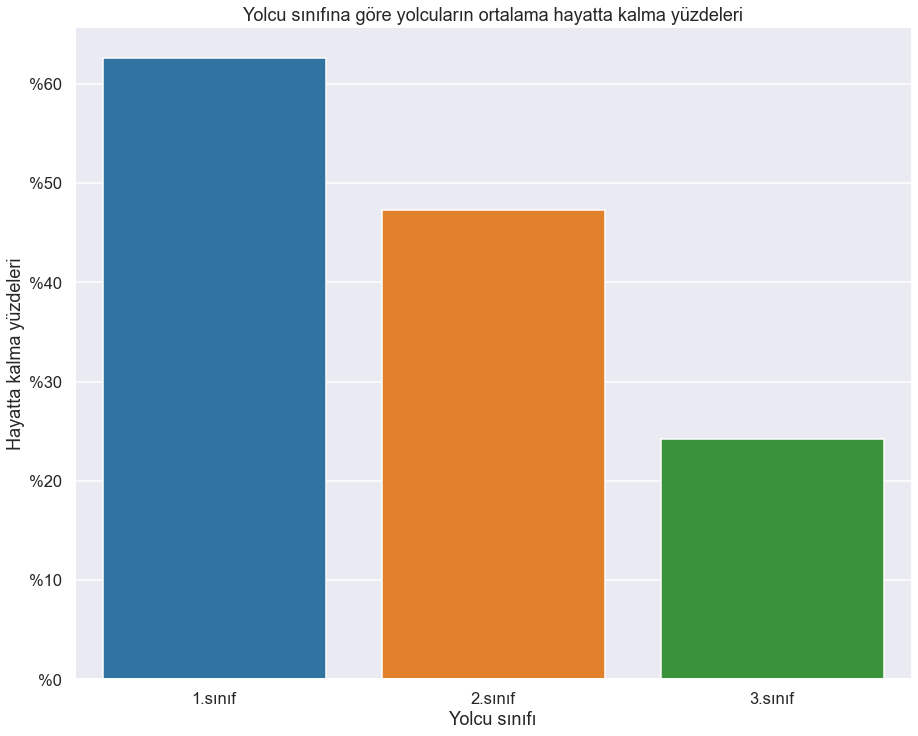

In [7]:
#Yolcuların seyahat sınıfına göre hayatta kalma yüzdeleri
sns.set_context("talk")
plt.figure(figsize=(15, 12))
g = sns.barplot("Pclass", "Survived", data=train, ci=None)
g.set_yticklabels(["%0", "%10", "%20", "%30", "%40", "%50", "%60", "%70"])
g.set_xticklabels(["1.sınıf", "2.sınıf", "3.sınıf"])
plt.title("Yolcu sınıfına göre yolcuların ortalama hayatta kalma yüzdeleri")
plt.xlabel("Yolcu sınıfı")
plt.ylabel("Hayatta kalma yüzdeleri")

Text(0.5, 0, 'Cinsiyet')

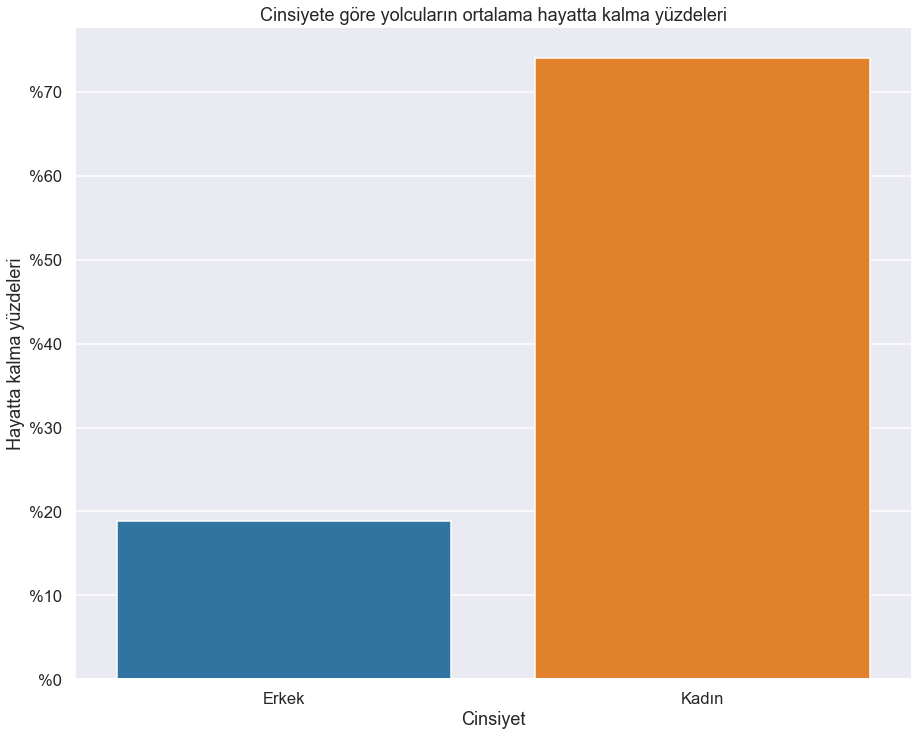

In [8]:
#Hayatta kalanların cinsiyete göre yüzdesel dağılımı
sns.set_context("talk")
plt.figure(figsize=(15, 12))
g = sns.barplot("Sex", "Survived", data=train, ci=None)
g.set_yticklabels(["%0", "%10", "%20", "%30", "%40", "%50", "%60", "%70", "%80"])
g.set_xticklabels(["Erkek", "Kadın"])
plt.title("Cinsiyete göre yolcuların ortalama hayatta kalma yüzdeleri")
plt.ylabel("Hayatta kalma yüzdeleri")
plt.xlabel("Cinsiyet")

Text(0, 0.5, 'Yaş')

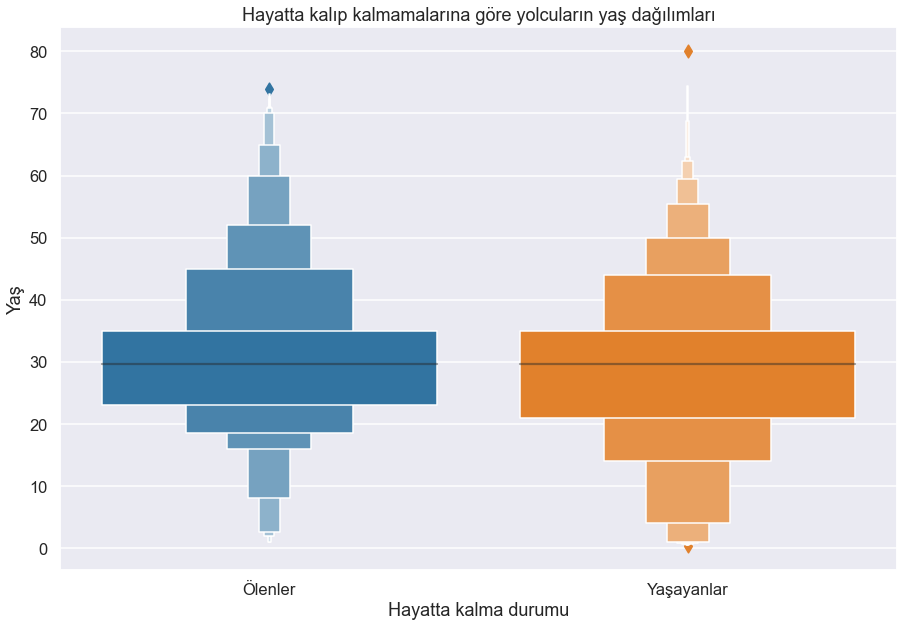

In [9]:
#Yolcuların hayatta kalma durumlarına göre yaşlarının dağılımını gösteren kutu grafiği
sns.set_context("talk")
plt.figure(figsize=(15, 10))
a = sns.boxenplot("Survived", "Age", data=train)
a.set_xticklabels(["Ölenler", "Yaşayanlar"])
plt.title("Hayatta kalıp kalmamalarına göre yolcuların yaş dağılımları")
plt.xlabel("Hayatta kalma durumu")
plt.ylabel("Yaş")

Text(0.5, 0, 'Hayatta kalma durumu')

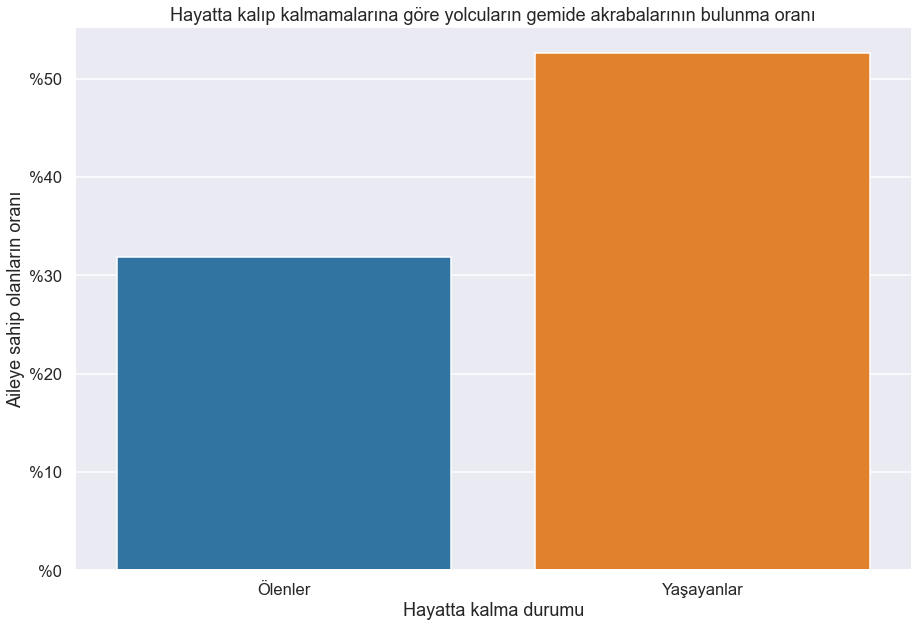

In [10]:
#Hayatta kalan ve ölen yolcuların gemideki akrabası olan ve olmayanların oranını gösteren kutu grafiği
sns.set_context("talk")
plt.figure(figsize=(15, 10))
a = sns.barplot("Survived", "has_family", data=train, ci=None)
a.set_yticklabels(["%0", "%10", "%20", "%30", "%40", "%50", "%60"])
a.set_xticklabels(["Ölenler", "Yaşayanlar"])
plt.title("Hayatta kalıp kalmamalarına göre yolcuların gemide akrabalarının bulunma oranı")
plt.ylabel("Aileye sahip olanların oranı")
plt.xlabel("Hayatta kalma durumu")

Text(0.5, 0, 'Hayatta kalma durumu')

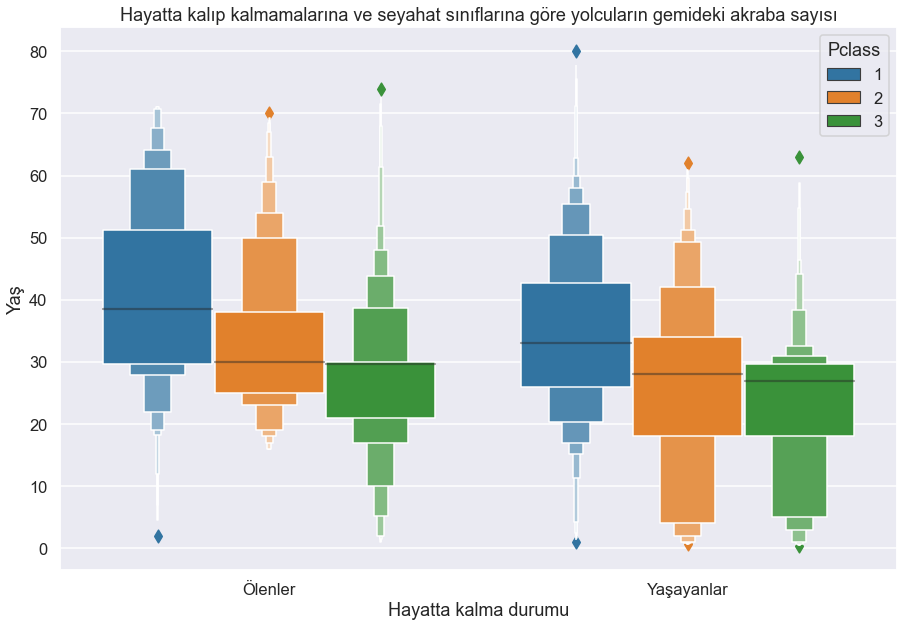

In [11]:
#Yolcuların seyahat sınıflarına ve hayatta kalıp kalmama durumlarına göre yaşlarının dağılımını gösteren kutu grafiği
sns.set_context("talk")
plt.figure(figsize=(15, 10))
a = sns.boxenplot("Survived", "Age", hue="Pclass", data=train)
a.set_xticklabels(["Ölenler", "Yaşayanlar"])
plt.title("Hayatta kalıp kalmamalarına ve seyahat sınıflarına göre yolcuların gemideki akraba sayısı")
plt.ylabel("Yaş")
plt.xlabel("Hayatta kalma durumu")

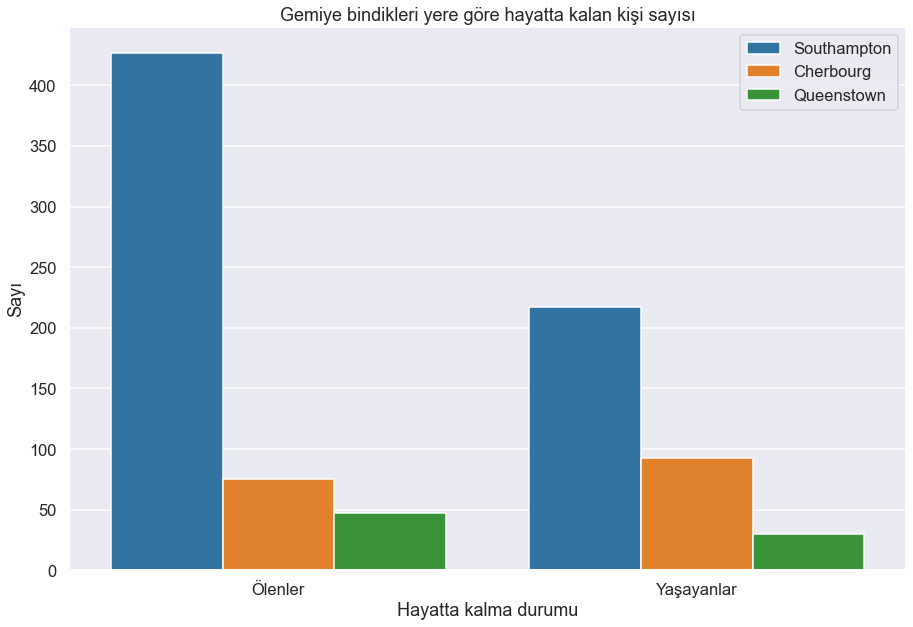

In [12]:
#Yolcuların seyahat sınıflarına ve hayatta kalıp kalmama durumlarına göre yaşlarının dağılımını gösteren kutu grafiği
sns.set_context("talk")
ax = plt.subplots(figsize=(15, 10))
a = sns.countplot("Survived", hue="Embarked", data=train)
a.set_xticklabels(["Ölenler", "Yaşayanlar"])
plt.title("Gemiye bindikleri yere göre hayatta kalan kişi sayısı")
plt.ylabel("Sayı")
plt.xlabel("Hayatta kalma durumu")
plt.legend(["Southampton", "Cherbourg", "Queenstown"])
plt.show()